### Import Dependencies

In [1]:
# data manipulation 
import pandas as pd
import numpy as np

# model tuning and metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


# visualization 
import seaborn as sns 
import matplotlib.pyplot as plt
from yellowbrick.model_selection import FeatureImportances


### Data Import and Test/Validation Splits

In [82]:
# read in cleaned df and split into feature/target sets
df = pd.read_pickle('final_df.pkl')
X = df.drop(columns='label')
y = df['label']

In [72]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)

# split validation from train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=77, stratify=y_train)

### Addressing Imbalance
Given the curated nature of the dataset, we have some obvious imbalance to address as our number of bot observations vastly outnumbers our real human data.

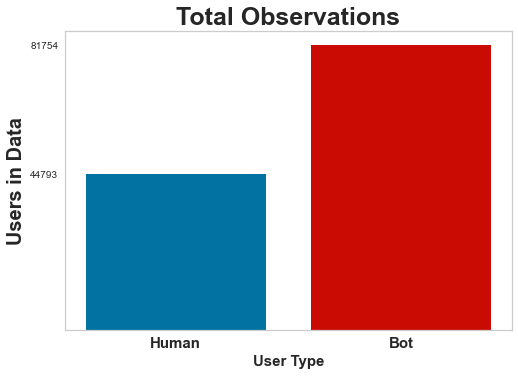

In [131]:
plt.bar([1,0], y.value_counts(), tick_label=['Bot', 'Human'], color=('r', 'b'),**{})
plt.title('Total Observations', fontsize=25, weight='bold')
plt.xlabel('User Type', fontsize=15, weight='bold')
plt.ylabel('Users in Data', fontsize=20, weight='bold')
plt.xticks(fontsize=15, weight='bold')
plt.yticks(ticks=[y.value_counts()[0], y.value_counts()[1]])
plt.grid(None)

We have a couple ways to approach this -- over or undersampling. Given the presence of strong outliers and the relatively large amount of overall data, we will likely fair as well or better with random resampling as with synthetic techniques. To over or undersample is a different question. Let's try both and compare.

In [140]:
# let's upsample the human training data
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)

X_train_ros, y_train_ros = ros.fit_sample(X_train,y_train)
X_train_rus, y_train_rus = rus.fit_sample(X_train,y_train)

We also have a significant amount of missing values in one column: default_profile, which seems like it may be a relatively important predictor. We'll go ahead an impute it. We can't apply basic imputation methods like mean imputation to this categorical data, so we'll opt for KNN imputation. 

KNN imputation will require us to scale our features as well. The large outliers in our data make mean and standard deviation poorly representative distribution metrics, so we'll use RobustScaler instead of StandardScaler since it will allow us to center on our IQR instead of mean. 

We'll combine this scaling and imputation into a single step completed outside of our modeling pipeline since model convergence will only gain from scaling and our imputation method is relatively expensive. 

It's important to note that we fit our scaler and imputer to our training data, and use those training set parameters on our validation and test sets to avoid data leakage. For this reason, we separately

In [141]:
# scaling and imputation steps -- we don't want these in a Pipeline because KNN imputation takes too long

def rob_sca_knn_imp(X_tr,X_te, X_va,k=3):
    # robust scaling, needed for KNN imputation
    scaler = RobustScaler().fit(X_tr)
    X_tr = pd.DataFrame(scaler.transform(X_tr), columns=X.columns)
    X_te = pd.DataFrame(scaler.transform(X_te), columns=X.columns)
    X_va = pd.DataFrame(scaler.transform(X_va), columns=X.columns)

    # knn imputation for default_profile, roughly 9k missing values
    imputer = KNNImputer(n_neighbors=k).fit(X_tr)
    X_tr = pd.DataFrame(imputer.transform(X_tr), columns=X_tr.columns)
    X_te = pd.DataFrame(imputer.transform(X_te), columns=X_tr.columns)
    X_va = pd.DataFrame(imputer.transform(X_va), columns=X_tr.columns)

    return X_tr, X_te, X_va

X_train_ros, X_test_ros, X_val_ros = rob_sca_knn_imp(X_train_ros, X_test, X_val)
X_train_rus, X_test_rus, X_val_rus = rob_sca_knn_imp(X_train_rus, X_test, X_val)


### Model Pipelining

In [142]:
def baseline_models(X_tr,y_tr,X_va,y_va):
    """
    fit and run untuned models to make baseline comparisons
    """
    baseline = pd.DataFrame(columns=['TrainF1', 'ValF1', 'TrainAcc', 'ValAcc', 'TrainRec', 'ValRec'])

    models = [LogisticRegression(C=1, max_iter=2000), 
              KNeighborsClassifier(n_neighbors=5),
              GaussianNB(),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              XGBClassifier()
              ]
    score_table = []
    for model in models:
        mod = model
        mod.fit(X_tr, y_tr)
        preds_tr = mod.predict(X_tr)
        preds_va = mod.predict(X_va)
        scores = [f1_score(y_tr, preds_tr), 
                  f1_score(y_va, preds_va), 
                  precision_score(y_tr, preds_tr), 
                  precision_score(y_va, preds_va), 
                  recall_score(y_tr, preds_tr), 
                  recall_score(y_va, preds_va)]
        score_table.append(scores)

    baseline = pd.DataFrame(score_table, columns=['TrainF1', 'ValF1', 'TrainAcc', 'ValAcc', 'TrainRec', 'ValRec'])
    baseline['Model'] = ['LogReg', 'KNN', 'GaussNB', 'DecTree', 'RandFor', 'XGB']   

    return baseline.set_index('Model')
    
baselines_ros = baseline_models(X_train_ros, y_train_ros, X_val_ros, y_val)
baselines_rus = baseline_models(X_train_rus, y_train_rus, X_val_rus, y_val)

In [143]:
baselines_ros

,TrainF1,ValF1,TrainAcc,ValAcc,TrainRec,ValRec
Model,,,,,,
LogReg,0.855899,0.895225,0.814496,0.888113,0.901737,0.902452
KNN,0.960016,0.949665,0.971447,0.962735,0.948850,0.936946
GaussNB,0.774691,0.858859,0.636841,0.759423,0.988706,0.988258
DecTree,0.999827,0.946970,0.999837,0.944894,0.999817,0.949055
RandFor,0.999827,0.964087,0.999817,0.976237,0.999837,0.952235
XGB,0.972788,0.963538,0.984569,0.978860,0.961286,0.948688


In [144]:
baselines_rus

,TrainF1,ValF1,TrainAcc,ValAcc,TrainRec,ValRec
Model,,,,,,
LogReg,0.859305,0.896142,0.818791,0.888969,0.904037,0.903431
KNN,0.951843,0.949139,0.953852,0.965223,0.949842,0.933582
GaussNB,0.778585,0.861693,0.642144,0.764121,0.988651,0.987829
DecTree,0.999851,0.948050,0.999851,0.960578,0.999851,0.935845
RandFor,0.999851,0.962526,0.999851,0.982546,0.999851,0.943306
XGB,0.974207,0.963007,0.982333,0.980968,0.966214,0.945691


#### Model Performance
* The tree-based models appear to dominate our baselines, though KNN actually outperforms Decision Tree's F1 on our validation set.
* XGBoost is surprisingly outperformed on all metrics in both training and validation sets (except validation accuracy) by both standard Decision Tree and Random Forest models. 
* These baseline models are entirely untuned, so greater performance differences may emerge as we adjust our hyperparameters.

#### Sampling Differences
* Decision Trees perform slightly better with undersampling
* Random Forest performs better on undersampled training, but better on validation scaled and imputed on oversampled parameters
* XGBoost is a mixed bag, performing marginally better  on F1 when oversampled, but differences are all in the 0.2%-0.5% range and inconsistent across metrics and data set



In [ ]:
confusion_matrix(y_test, forest_pred)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())

In [ ]:
forest2 = RandomForestClassifier()
viz = FeatureImportances(forest2)
viz.fit(X_train_final, y_train_res)
viz.show()

In [10]:
knn_pipe = Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=3)), ('knn', KNeighborsClassifier(n_neighbors=5))])
knn_pipe.fit(X_train_res, y_train_res)
knn_pipe.score(X_test, y_test)

0.936270248913473

In [13]:
rf_pipe = Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=3)), ('rf', RandomForestClassifier())])
rf_pipe.fit(X_train_res, y_train_res)
rf_pipe.score(X_test, y_test)

0.9540497826945871

In [18]:
lr_pipe = Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=3)), ('lr', LogisticRegression())])
lr_pipe.fit(X_train_res, y_train_res)
lr_pipe.score(X_test, y_test)

/Users/Kelso/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8596207032793363

In [15]:
knn_f1 = f1_score(y_test, knn_pipe.predict(X_test))

0.949961222273926

In [17]:
rf_f1 = f1_score(y_test, rf_pipe.predict(X_test))

0.9640461248338331

In [19]:
lr_f1 = f1_score(y_test, lr_pipe.predict(X_test))

0.89187790998448

In [27]:
lr_params = {'lr__max_iter':[2000],
              'lr__penalty':['l1','l2'], 
              'lr__C':np.logspace(-4,4,20)}

clf_lr = GridSearchCV(lr_pipe, param_grid = lr_params, cv = 5, verbose = 100, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 45.2min


KeyboardInterrupt: 

In [ ]:
clf_lr = GridSearchCV(lr_pipe)